# Investigating the Baseball Dataset

## Background Information

The Lahman Baseball Database, available <a href="http://www.seanlahman.com/baseball-archive/statistics/">here</a>, contains pitching, hitting, and fielding statistics for Major League Baseball from 1871 through 2014.  It includes data from the two current leagues (American and National), the four other "major" leagues (American Association, Union Association, Players League, and Federal League), and the National Association of 1871-1875. The database was created by Sean Lahman in 1994, in an effort to create an openly-available repository of baseball statistics.

## Question To Investigate

### What are the factors affecting a baseball player's lifespan?
The Lahman DB contains a Master.csv file, whose documentation reads:

<code>2.1 MASTER table


playerID       A unique code asssigned to each player.  The playerID links
                 the data in this file with records in the other files.
birthYear      Year player was born
birthMonth     Month player was born
birthDay       Day player was born
birthCountry   Country where player was born
birthState     State where player was born
birthCity      City where player was born
deathYear      Year player died
deathMonth     Month player died
deathDay       Day player died
deathCountry   Country where player died
deathState     State where player died
deathCity      City where player died
  ...                  ... </code>

In [2]:
import pandas as pd
import numpy as np
df_master = pd.read_csv('core/Master.csv')
df_master[df_master.deathYear.notnull()]['deathYear'].count()

9336

Thus there are 9336 potential athletes for whom we can examine their longevity, and investigate several independent variables looking for statistically significant variation. 

**Questions to Explore**: For this project, I will be exploring whether there are sport-specific variables that significantly affect the longevity of a player. In particular, I will consider whether salary, teams for which a player has played, induction into the Hall of Fame, and number of World Series won affect longevity.

## Data Wrangling
Since we want to look at a player's age upon death, first we'll examine the data of player longevity that we have, in order to verify that the data is clean and that missing values are handled appropriately.

In [3]:
df_master[df_master.deathYear.notnull()].describe()

/home/anton/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height
count,9327.000000,9180.000000,9041.000000,9336.000000,9335.000000,9334.000000,8608.000000,8675.000000
mean,1895.843144,6.612527,15.518637,1963.850364,6.484092,15.570281,175.986176,71.090144
std,25.242584,3.478049,8.756774,31.506369,3.528685,8.778580,16.276167,2.398589
min,1820.000000,1.000000,1.000000,1872.000000,1.000000,1.000000,65.000000,43.000000
25%,NaN,NaN,NaN,1942.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,1966.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,1989.000000,NaN,NaN,NaN,NaN
max,1992.000000,12.000000,31.000000,2016.000000,12.000000,31.000000,320.000000,81.000000


Clearly we have missing values, since the count for the deathYear column exceeds that of every other column. While months and days of births and deaths might be imputed from a median, or set to default values (equivalent to dropping them and looking at age as an integer), birthYear would not make sense to impute, so rows missing that value will be dropped.

In [4]:
default_dates = {'birthMonth': 1, 'birthDay': 1, 'deathMonth': 1, 'deathDay': 1}
df_age = df_master[df_master.deathYear.notnull() & df_master.birthYear.notnull()].fillna(default_dates).copy()
df_age.describe()

/home/anton/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height
count,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,8604.000000,8672.000000
mean,1895.843144,6.524070,15.073443,1963.910046,6.483757,15.567492,175.988610,71.090752
std,25.242584,3.520632,8.977506,31.460792,3.529802,8.782276,16.279106,2.398573
min,1820.000000,1.000000,1.000000,1872.000000,1.000000,1.000000,65.000000,43.000000
25%,1877.000000,3.000000,7.000000,1942.000000,3.000000,8.000000,NaN,NaN
50%,1895.000000,7.000000,15.000000,1966.000000,6.000000,15.000000,NaN,NaN
75%,1915.000000,10.000000,23.000000,1989.000000,10.000000,23.000000,NaN,NaN
max,1992.000000,12.000000,31.000000,2016.000000,12.000000,31.000000,320.000000,81.000000


We see that the weight and height values are still missing for some players. In an earlier iteration of this project, these missing values were imputed from the grouped medians of the available data - but as this artificially distorts the distributions, and in fact we're not concerned with these variables at all, they'll simply be dropped.

Having filled the missing values, we'll calculate the player ages upon death and store this in a new column called Age:

In [5]:
def update_age_columns():
    df_age['birth'] = pd.to_datetime(dict(year=df_age.birthYear, month=df_age.birthMonth, day=df_age.birthDay))
    df_age['death'] = pd.to_datetime(dict(year=df_age.deathYear, month=df_age.deathMonth, day=df_age.deathDay))
    df_age['age'] = (df_age.death-df_age.birth).astype('timedelta64[D]').astype(int) / 365.25

update_age_columns()

count    9327.000000
mean       68.063386
std        16.232458
min       -19.200548
25%        58.109514
50%        70.403833
75%        80.310746
max       132.755647
Name: age, dtype: float64

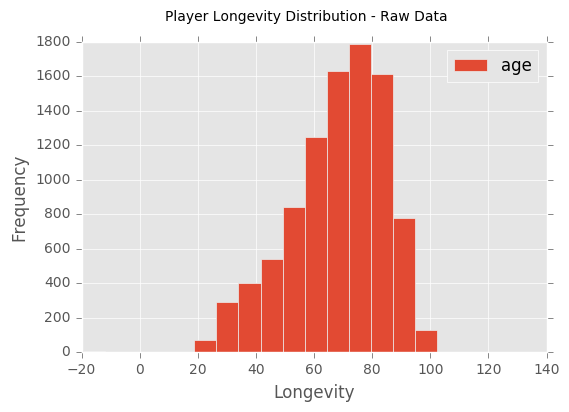

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
f = plt.figure()
ax = df_age['age'].plot(kind='hist', bins=20, legend=True);
f.suptitle('Player Longevity Distribution - Raw Data');
ax.set_xlabel('Longevity')
df_age['age'].describe()

Evidently we still have some room for concern - the minimum player age is -19.2, circumventing physical laws that restrict exceeding the speed of light, and the maximum age is 132.76, which is older than the oldest human on record (122 years). Let's examine some of these entries:

In [7]:
print(df_age['age'].nlargest(3))
print(df_age['age'].nsmallest(3))

5435     132.755647
7700     107.359343
10541    102.995209
Name: age, dtype: float64
8384    -19.200548
3825     19.540041
15779    20.290212
Name: age, dtype: float64


In fact it appears that only the two extreme entries may have mistaken information. Let's run a sanity check on them:

In [8]:
df_age.loc[df_age['age'].nlargest(2).index][['nameLast','nameFirst','birth','death']]

,nameLast,nameFirst,birth,death
5435,Flowers,Dickie,1850-01-01,1982-10-05
7700,Hoff,Red,1891-05-08,1998-09-17


Checking Wikipedia, in the case of <a href='https://en.wikipedia.org/wiki/Dickie_Flowers'>Dickie Flowers</a>, we can see that his date of death is actually 1892-10-06, so the 8 and 9 were simply reversed. In the case of <a href='https://en.wikipedia.org/wiki/Red_Hoff'>Red Hoff</a>, the dates are in fact correct, and he did live to 107 years old.

In [9]:
df_age.loc[df_age['age'].nsmallest(2).index][['nameLast','nameFirst','birth','death']]

,nameLast,nameFirst,birth,death
8384,Johnson,Lefty,1961-09-28,1942-07-17
3825,Dahl,Jay,1945-12-06,1965-06-21


The dates for <a href='https://en.wikipedia.org/wiki/Lefty_Johnson'>Lefty Johnson</a> are also incorrect - his birth year is actually 1862. <a href='https://en.wikipedia.org/wiki/Jay_Dahl'>Jay Dahl's</a> dates appear to be correct.

Having done this fact checking on the outliers, we'll correct those values and recalculate the age columns.

In [10]:
df_age.loc[5435,'deathYear'] = 1892
df_age.loc[8384,'birthYear'] = 1862
update_age_columns()

count    9327.000000
mean       68.064351
std        16.196012
min        19.540041
25%        58.109514
50%        70.403833
75%        80.302533
max       107.359343
Name: age, dtype: float64

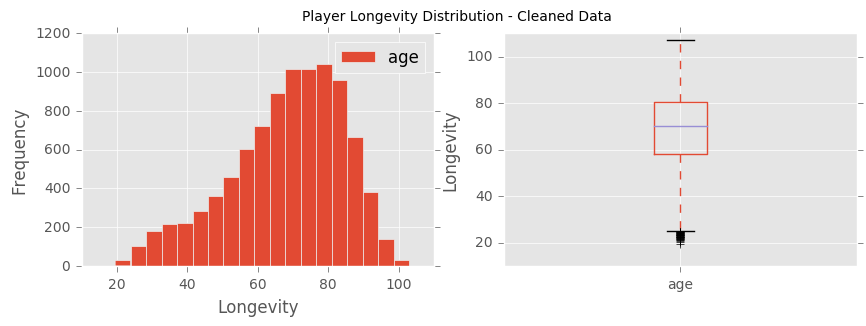

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 3))
df_age['age'].plot(kind='hist', bins=20, legend=True, ax=ax1)
df_age[['age']].boxplot(return_type='axes', ax=ax2);
ax1.set_xlabel('Longevity');
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Longevity')
f.suptitle('Player Longevity Distribution - Cleaned Data')

df_age['age'].describe()

With this distribution and statistics, I'm satisfied that the age data has been cleaned sufficiently. The histogram reveals a negatively skewed distribution for players' age, which concurs with my intuition on what distribution to have expected.

Next, since I'm interested in Hall of Fame, salary, teams for which each player has played, and World Series wins, I'll read in those CSVs, merge the tables, and inspect the quality of the data.

In [12]:
df_HOF = pd.read_csv('core/HallOfFame.csv')
df_salary = pd.read_csv('core/Salaries.csv')
df_batting = pd.read_csv('core/Batting.csv')
df_teams = pd.read_csv('core/Teams.csv')

Rather than use the raw salaries as provided, which contain salaries per year per athlete, I'll instead reduce the dimensionality of the data and consider the descriptive statistics of min, mean, and max salaries over a player's career.

In [13]:
df_salary_stats = pd.DataFrame({'min_salary': df_salary.groupby('playerID')['salary'].min(), 
                                'mean_salary': df_salary.groupby('playerID')['salary'].mean(),
                                'max_salary': df_salary.groupby('playerID')['salary'].max()},
                                index=df_salary.groupby('playerID')['salary'].groups)
df_salary_stats['playerID'] = df_salary_stats.index
df_age = df_age.merge(df_salary_stats, on='playerID', how='left')
df_age.describe()

/home/anton/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height,age,max_salary,mean_salary,min_salary
count,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,8604.000000,8672.000000,9327.000000,8.700000e+01,8.700000e+01,87.000000
mean,1895.832529,6.524070,15.073443,1963.900397,6.483757,15.567492,175.988610,71.090752,68.064351,1.440537e+06,7.390481e+05,227516.574713
std,25.235996,3.520632,8.977506,31.469044,3.529802,8.782276,16.279106,2.398573,16.196012,1.842788e+06,7.843830e+05,173766.738381
min,1820.000000,1.000000,1.000000,1872.000000,1.000000,1.000000,65.000000,43.000000,19.540041,6.750000e+04,6.500000e+04,60000.000000
25%,1877.000000,3.000000,7.000000,1942.000000,3.000000,8.000000,NaN,NaN,58.109514,NaN,NaN,NaN
50%,1895.000000,7.000000,15.000000,1966.000000,6.000000,15.000000,NaN,NaN,70.403833,NaN,NaN,NaN
75%,1915.000000,10.000000,23.000000,1989.000000,10.000000,23.000000,NaN,NaN,80.302533,NaN,NaN,NaN
max,1992.000000,12.000000,31.000000,2016.000000,12.000000,31.000000,320.000000,81.000000,107.359343,8.442981e+06,3.368731e+06,750000.000000


Interestingly, there are only 87 entires for salaries, so this is likely to be insufficient for any substantial analysis. Nevertheless, we'll have a look later.

Next, we'll look at HOF data:

In [14]:
df_inductees = df_HOF.loc[df_HOF.inducted == 'Y'][['playerID', 'inducted']].copy()
df_age = df_age.merge(df_inductees, on='playerID', how='left')
df_age['inducted'].fillna('N', inplace=True)
df_inductees.describe()

,playerID,inducted
count,312,312
unique,312,1
top,suttlmu99,Y
freq,1,312


The 312 count of inductees is reflective of actual numbers, as available on the <a href='http://baseballhall.org/hall-of-famers'>Baseball Hall of Fame website</a>. We'll go ahead and merge these with our available data. Notably, we see that:

In [15]:
print('{} of 312 Hall of Famers are deceased.'.format(df_age.loc[df_age['inducted'] == 'Y']['playerID'].count()))

243 of 312 Hall of Famers are deceased.


Next, we'll look at the Batting data, and attempt to discern which players played for which teams.

In [16]:
df_batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,...,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,28.0,40.0,4.0,...,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,28.0,44.0,10.0,...,27.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,29.0,39.0,11.0,...,16.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [17]:
print('There are {} (player, team) entries, of which {} are unique.'.format(len(df_batting[['playerID','teamID']].index),len(df_batting[['playerID','teamID']].drop_duplicates().index)))

There are 101332 (player, team) entries, of which 43764 are unique.


In order to understand which teams each player played for, we'll do a left merge of the age data with the player & teams data, allowing duplication of rows where a player has played on multiple teams (we'll later drop duplicates where appropriate).

In [18]:
df_player_teams = df_batting[['playerID','teamID']].drop_duplicates().copy()
df_age = df_age.merge(df_player_teams, on='playerID', how='left')
df_age.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,retroID,bbrefID,birth,death,age,max_salary,mean_salary,min_salary,inducted,teamID
0,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,aarot101,aaronto01,1939-08-05,1984-08-16,45.032170,NaN,NaN,NaN,N,ML1
1,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,aarot101,aaronto01,1939-08-05,1984-08-16,45.032170,NaN,NaN,NaN,N,ATL
2,abadijo01,1854.0,11.0,4.0,USA,PA,Philadelphia,1905.0,5.0,17.0,...,abadj101,abadijo01,1854-11-04,1905-05-17,50.529774,NaN,NaN,NaN,N,PH3
3,abadijo01,1854.0,11.0,4.0,USA,PA,Philadelphia,1905.0,5.0,17.0,...,abadj101,abadijo01,1854-11-04,1905-05-17,50.529774,NaN,NaN,NaN,N,BR2
4,abbated01,1877.0,4.0,15.0,USA,PA,Latrobe,1957.0,1.0,6.0,...,abbae101,abbated01,1877-04-15,1957-01-06,79.726215,NaN,NaN,NaN,N,PHI


Finally, we'll look at the total number of World Series wins per athlete. To accomplish this, we'll merge the Teams and Batting tables on TeamID and YearID, thereby mapping the WSWin column to each athlete according to whether or not they won the Series that year. Grouping by playerID and summing the WSWin column, we'll get the total number of World Series win per athlete.

To ensure that we're not duplicating rows along the way, we'll check how many entries there are at the beginning and end of the merge process.

In [19]:
df_teams['WSWin'] = df_teams['WSWin'].apply(lambda x: 1 if x=='Y' else 0)
print('Total {} World Series winning teams.'.format(df_teams[['teamID','yearID','WSWin']]['WSWin'].sum()))
print(df_batting['yearID'].count())

Total 116 World Series winning teams.
101332


In [20]:
df_wins = df_batting.merge(df_teams, on=['teamID','yearID'])
print('After merging, total {} World Series winning teams.'.format(df_wins[['teamID','yearID','WSWin']].drop_duplicates()['WSWin'].sum()))

After merging, total 116 World Series winning teams.


In [21]:
# Group by playerID and sum the World Series wins per athlete.
df_wins = pd.DataFrame(df_wins[['playerID','WSWin']].groupby('playerID')['WSWin'].sum())
print('There are a total {} World Series wins when summing by player, for approximately {:.2f} players per team.'.format(df_wins['WSWin'].sum(),df_wins['WSWin'].sum()/df_teams[['teamID','yearID','WSWin']]['WSWin'].sum()))

There are a total 3974 World Series wins when summing by player, for approximately 34.26 players per team.


As a last step in the data wrangling process, we'll merge these statistics per player back with the original df_age DataFrame.

In [22]:
df_wins['playerID'] = df_wins.index
df_age = df_age.merge(df_wins, on='playerID', how='left')
df_age.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,bbrefID,birth,death,age,max_salary,mean_salary,min_salary,inducted,teamID,WSWin
0,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,aaronto01,1939-08-05,1984-08-16,45.032170,NaN,NaN,NaN,N,ML1,0.0
1,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,aaronto01,1939-08-05,1984-08-16,45.032170,NaN,NaN,NaN,N,ATL,0.0
2,abadijo01,1854.0,11.0,4.0,USA,PA,Philadelphia,1905.0,5.0,17.0,...,abadijo01,1854-11-04,1905-05-17,50.529774,NaN,NaN,NaN,N,PH3,0.0
3,abadijo01,1854.0,11.0,4.0,USA,PA,Philadelphia,1905.0,5.0,17.0,...,abadijo01,1854-11-04,1905-05-17,50.529774,NaN,NaN,NaN,N,BR2,0.0
4,abbated01,1877.0,4.0,15.0,USA,PA,Latrobe,1957.0,1.0,6.0,...,abbated01,1877-04-15,1957-01-06,79.726215,NaN,NaN,NaN,N,PHI,1.0


Finally, the data wrangling phase is complete and we can begin to analyze the data.

## Relationship Between Salary and Player Longevity

To begin, we'll simply plot the two variables and attempt to observe any interesting results.

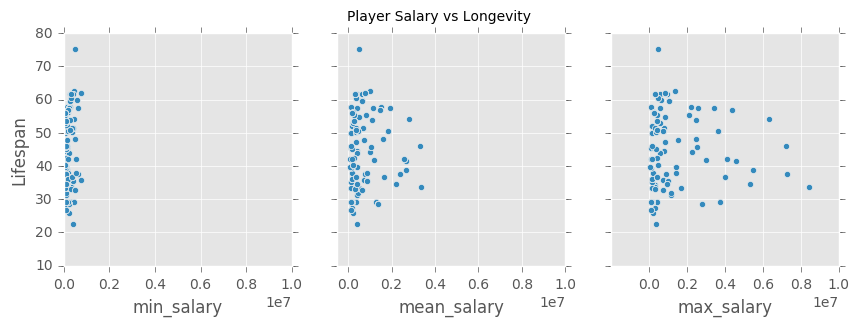

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
plt.suptitle('Player Salary vs Longevity');
xticks = [0.0e7, 0.2e7, 0.4e7, 0.6e7, 0.8e7, 1.0e7]
df_age[['age','min_salary']].plot(kind='scatter', x='min_salary', y='age', ax=ax1, xticks=xticks);
df_age[['age','mean_salary']].plot(kind='scatter', x='mean_salary', y='age', ax=ax2, xticks=xticks);
df_age[['age','max_salary']].plot(kind='scatter', x='max_salary', y='age', ax=ax3, xticks=xticks);
#ax2.get_yaxis().set_ticklabels([])
#ax1.set_xlabel('Time (s)'); ax2.set_xlabel('Time (s)');
#ax1.legend(); ax2.legend();
ax1.set_ylabel('Lifespan');

Rather clearly, no trend in the data immediately jumps out. There doesn't appear to be any linear correlation, either, which we can easily verify:

In [24]:
df_age[['age','min_salary','mean_salary','max_salary']].corr()['age']

age            1.000000
min_salary     0.156506
mean_salary   -0.070938
max_salary    -0.119520
Name: age, dtype: float64

These Pearson's r coefficients are very near zero, indicating no linear correlation.

## Relationship Between Hall of Fame Induction and Player Longevity

Next we'll look at whether induction into the Baseball Hall of Fame in any way shifts the distribution of player longevity:

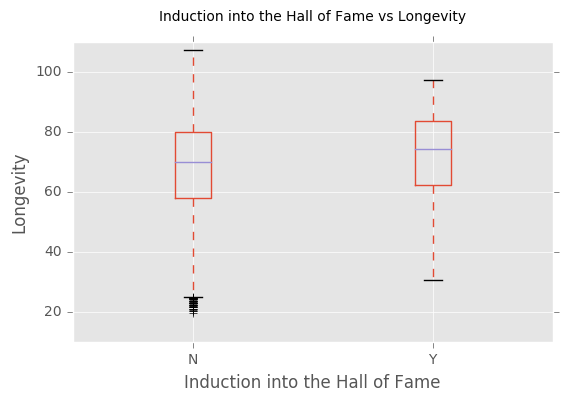

In [25]:
df_age[['age','inducted']].boxplot(by='inducted', return_type='axes');
plt.suptitle('Induction into the Hall of Fame vs Longevity');
plt.ylabel('Longevity')
plt.xlabel('Induction into the Hall of Fame')
plt.title('');

The distribution of player ages having been inducted into the Hall of Fame has shorter tails and fewer outliers than does the population minus that set, while otherwise looking very similar. At this point we could do hypothesis testing to see whether the sample of inductees is from the same distribution as the population, whose parameters we know - as a guess, the null hypothesis would not be rejected. 

## Relationship Between Teams Played For and Longevity

Next we'll look at similar boxplots, grouping instead by teams for which the players have played. This might give a sense as to whether, say, players that played for Toronto live longer.

In [44]:
df_age[['age','teamID']].groupby('teamID').describe()

age
teamID                 
ALT    count  17.000000
       mean   62.071426
       std    18.487432
       min    29.032170
       25%    47.312799
       50%    68.613279
       75%    75.299110
       max    89.344285
ANA    count   1.000000
       mean   56.815880
       std          NaN
       min    56.815880
       25%    56.815880
       50%    56.815880
       75%    56.815880
       max    56.815880
ARI    count   2.000000
       mean   31.104723
       std     3.682182
       min    28.501027
       25%    29.802875
       50%    31.104723
       75%    32.406571
       max    33.708419
ATL    count  65.000000
       mean   57.287717
       std    14.257392
       min    26.184805
       25%    48.722793
       50%    59.893224
...                 ...
WS7    std    17.719583
       min    26.201232
       25%    52.681725
       50%    70.231348
       75%    76.298426
       max    91.356605
WS8    count  72.000000
       mean   61.413834
       std    18.458790
       min    24.396988
       25%    49.451745
       50%    63.908282
       75%    74.958932
       max    99.561944
WS9    count  37.000000
       mean   60.710213
       std    18.735128
       min    20.290212
       25%    50.781656
       50%    63.731691
       75%    71.140315
       max    94.551677
WSU    count  38.000000
       mean   62.837854
       std    17.646760
       min    29.253936
       25%    49.327858
       50%    65.355236
       75%    77.004107
       max    92.640657

[1184 rows x 1 columns]

At a glance these statistics don't reveal any insights. It's clear that we're looking simultaneously at a very large number of teams, some of whom have only a few players linked to them, and hence may be skewing our data. Below, we'll restrict this collection to only teams that have at least 100 players linked to them, and generate boxplots of the player longevity:

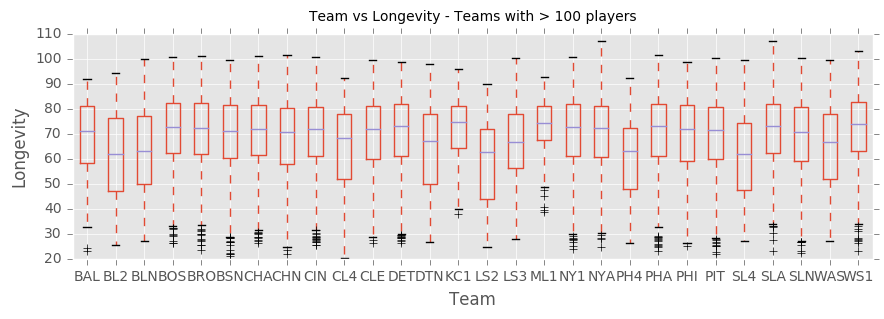

In [28]:
teams = (df_age[['age','teamID']].groupby('teamID').agg('count') > 100).copy()
teams.rename(columns={'age':'min100players'}, inplace=True)
min100 = list(teams[teams['min100players']].index)
min100
df_age[['age','teamID']].loc[df_age['teamID'].isin(min100)].boxplot(by='teamID', return_type='axes', figsize=(10,3));
plt.suptitle('Team vs Longevity - Teams with > 100 players');
plt.ylabel('Longevity')
plt.xlabel('Team')
plt.title('');

Some of the team boxplots above - BL2, LS2, PH4, SL4 - deviate substantially from the population as seen before. Let's find out more about them:

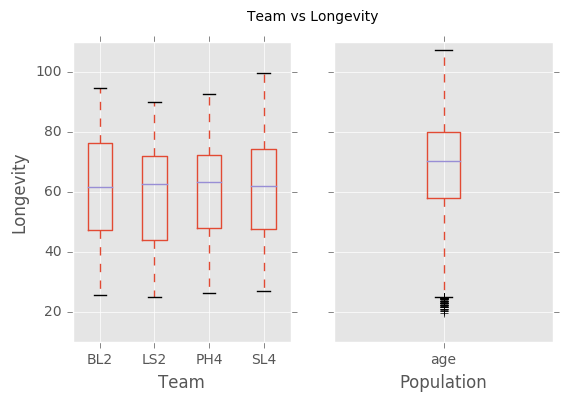

In [29]:
odd_teams = ['BL2', 'LS2', 'PH4', 'SL4']
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
df_age[['age','teamID']].loc[df_age['teamID'].isin(odd_teams)].boxplot(by='teamID', return_type='axes', ax=ax1);
df_age[['age']].boxplot(return_type='axes', ax=ax2);
ax1.set_ylabel('Longevity')
ax1.set_xlabel('Team')
ax2.set_xlabel('Population')
plt.suptitle('Team vs Longevity');
ax1.set_title('');

In [30]:
df_teams[['teamID','name','lgID']].loc[df_teams['teamID'].isin(odd_teams)].drop_duplicates()

,teamID,name,lgID
95,BL2,Baltimore Orioles,AA
101,LS2,Louisville Eclipse,AA
102,PH4,Philadelphia Athletics,AA
105,SL4,St. Louis Brown Stockings,AA
123,SL4,St. Louis Browns,AA
164,LS2,Louisville Colonels,AA


Interestingly, these teams have mean lifespans about 10 years below the population mean, and 25-75 quantiles as much as 15 years below the population. All the teams above belonged to the American Association league, which existed only from 1882 to 1891. Hence the discrepancy in lifespan can largely be attributed to the increase in <a href='http://u.demog.berkeley.edu/~andrew/1918/figure2.html'>life expectancy throughout the 20th century</a> - in 1900, the male life expectancy was 46.3 years, as compared with 73.8 in 1998. 

## Relationship Between World Series Wins and Longevity

Finally, we'll look at whether winning one or multiple World Series affects the longevity distribution.

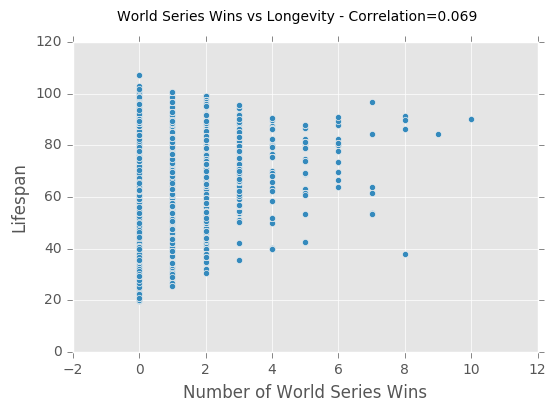

In [31]:
df_age[['age','WSWin']].plot(kind='scatter', x='WSWin', y='age');
plt.suptitle('World Series Wins vs Longevity - Correlation={:.3f}'.format(df_age[['age','WSWin']].corr()['age']['WSWin']));
#ax2.get_yaxis().set_ticklabels([])
#ax1.set_xlabel('Time (s)'); ax2.set_xlabel('Time (s)');
#ax1.legend(); ax2.legend();
plt.ylabel('Lifespan');
plt.xlabel('Number of World Series Wins');

Interestingly, up to 5 World Series wins, there's a distinct narrowing of the range of values. At 6 and above, the pattern is broken and the values are erratic. Let's look at boxplots for the zero to five wins, however:

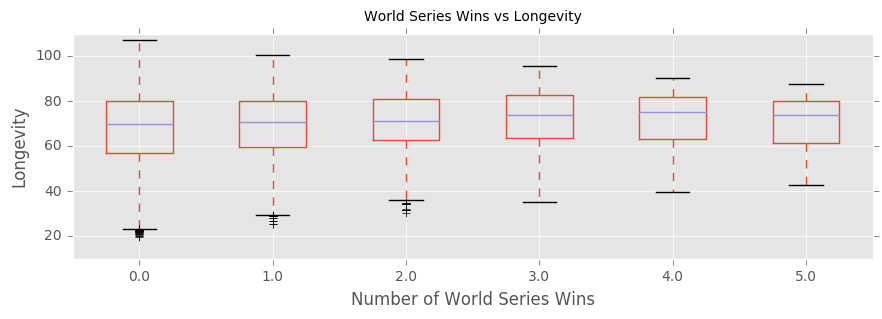

In [32]:
df_age[['age','WSWin']].loc[df_age['WSWin'] < 6].boxplot(by='WSWin', return_type='axes', figsize=(10,3));
plt.suptitle('World Series Wins vs Longevity');
plt.ylabel('Longevity')
plt.xlabel('Number of World Series Wins')
plt.title('');

The narrowing of the distribution from the bottom end of longevity can likely be explained that the number of World Series Wins variable itself has a temporal component - in order to win more World Series, an athlete needs to have lived longer, thus athletes dying at younger ages would not have been able to win as many.

From the high end of the longevity spectrum, it's *possible* that those winning more series were subject to considerable overtraining or doping in some fashion that may have decreased their life expectancy. Additionally, it's known that some great athletes possess genetic conditions that enhance their performance - such as an excess of oxygen-carrying red blood cells - which too can potentially detract from longevity. 

A more likely explanation for the reduction in the high end of the distrbution as the number of wins increases is that this data set includes World Series wins as far back as 1903, when only 16 teams made up the league. Thus the likelihood of players winning a World Series during their career was twice as high at the beginning of the century as it is now, when there are almost twice as many teams in the league. With the change in life expectancy over the century as mentioned before, it's likely that the greater the number of World Series wins, the more likely a player is to have been alive earlier in the century. 

## Conclusions

The data examined above demonstrates a narrowing distribution of player lifespan as the max salary and number of World Series wins of an athlete increases. These plots are reproduced below:

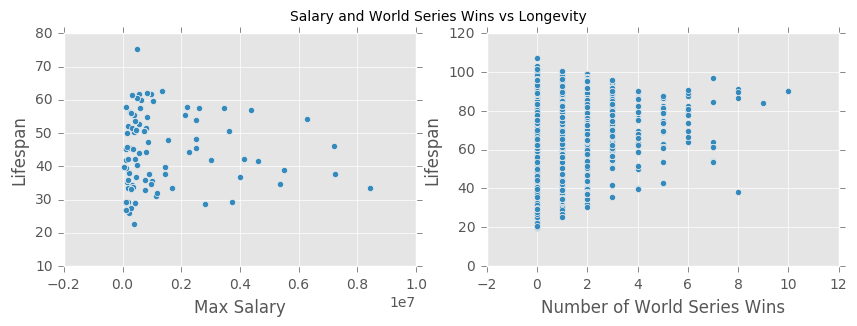

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 3))
plt.suptitle('Salary and World Series Wins vs Longevity');
df_age[['age','max_salary']].plot(kind='scatter', x='max_salary', y='age', ax=ax1);
df_age[['age','WSWin']].plot(kind='scatter', x='WSWin', y='age', ax=ax2);
ax1.set_ylabel('Lifespan');
ax2.set_ylabel('Lifespan');
ax1.set_xlabel('Max Salary');
ax2.set_xlabel('Number of World Series Wins');

As explained in the analysis of World Series wins, the narrowing of the distribution likely has most to do with the era that the players were alive - the more wins, the earlier in the century they were alive, and hence a naturally lower life expectancy.

In the case of maximum salary, the distribution does not narrow quite as distinctly, athough a narrowing effect is certainly discernible. As with World Series wins, the bottom end narrowing has most to do with the requirement of living longer in order to earn more. The narrowing of the higher end is <a href='http://jamanetwork.com/journals/jama/article-abstract/2513561'>open to speculation and poorly understood by academics</a>, though it is suggested that different income levels correlate with different health behaviours, which would have a material affect on life expectancy.

With respect to limitations of this report and dataset, it's worth noting that the Lahman Baseball dataset is purported to contain complete Major League Baseball statistics from 1871 through 2014. Thus, to the extent that the information is free of errors, it puts analysts in the privileged situation of dealing with the population rather than a sample. Nevertheless, it is clear from the amount of missing data that the dataset has considerably more information about modern-day players than about those in the early days of the game - many players from the 1800s, for example, are missing birthdays. Thus, while we may have a representative view of the data, we do not have a perfect view.

This report looked at several factors that may have affected player longevity, but the search was by no means exhaustive, and many other factors are potentially worthy of exploration. Player batting, for example, can be used as a measure of the physical activity of swinging a bat - could high numbers be an indicator for repetitive strain injuries, and be correlated with lower lifespan? 

Finally, this report would ideally be extended to calibrate a prediction model. Given what we know of an existing player's salary and World Series wins, can we predict his lifespan with any accuracy? Morbid, but interesting!